## tutorial example

In [1]:
import scvelo as scv
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

In [2]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo')  # for beautified visualization
adata = scv.datasets.dentategyrus()
scv.utils.show_proportions(adata)

Abundance of ['spliced', 'unspliced', 'ambiguous']: [0.69 0.08 0.23]


In [3]:
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)

Filtered out 11019 genes that are detected in less than 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:13) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


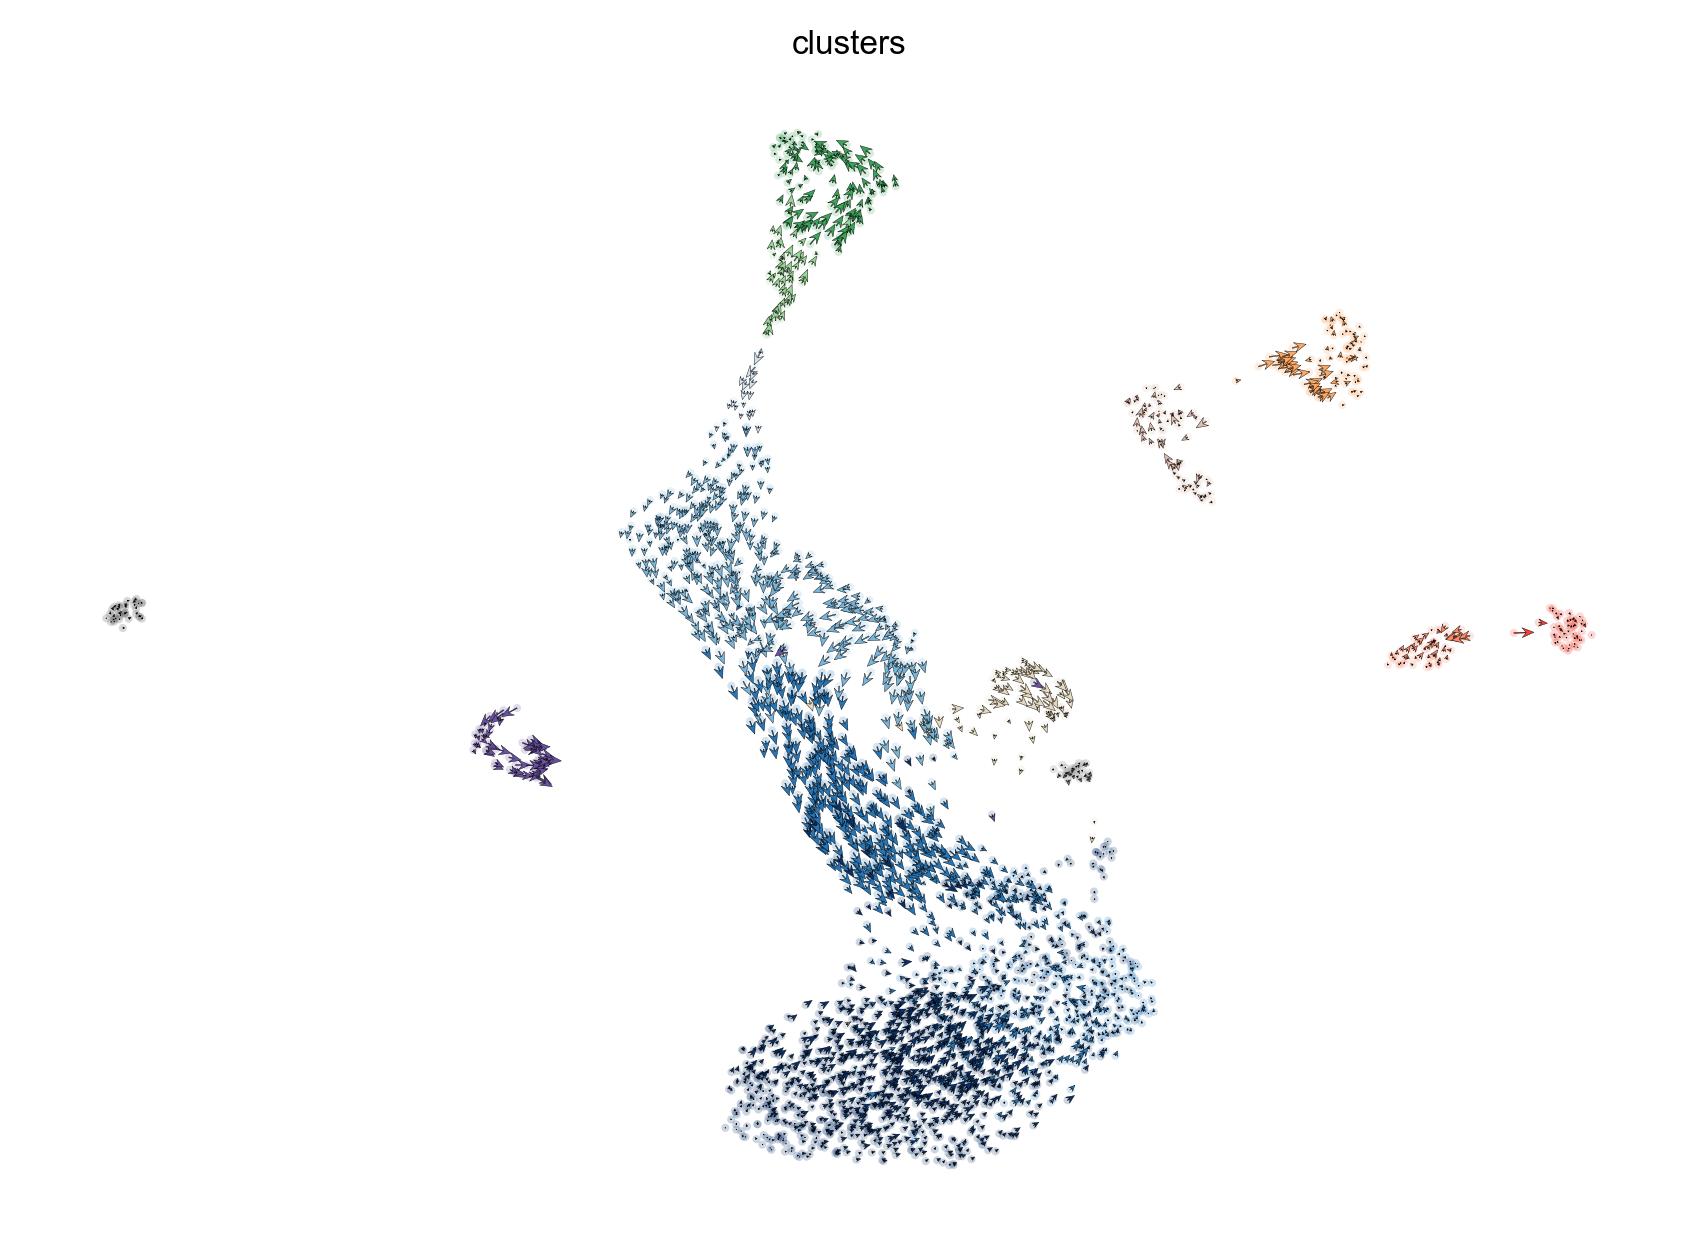

In [12]:
scv.pl.velocity_embedding(adata, basis='umap', arrow_length=1.2, arrow_size=1.2, dpi=150)

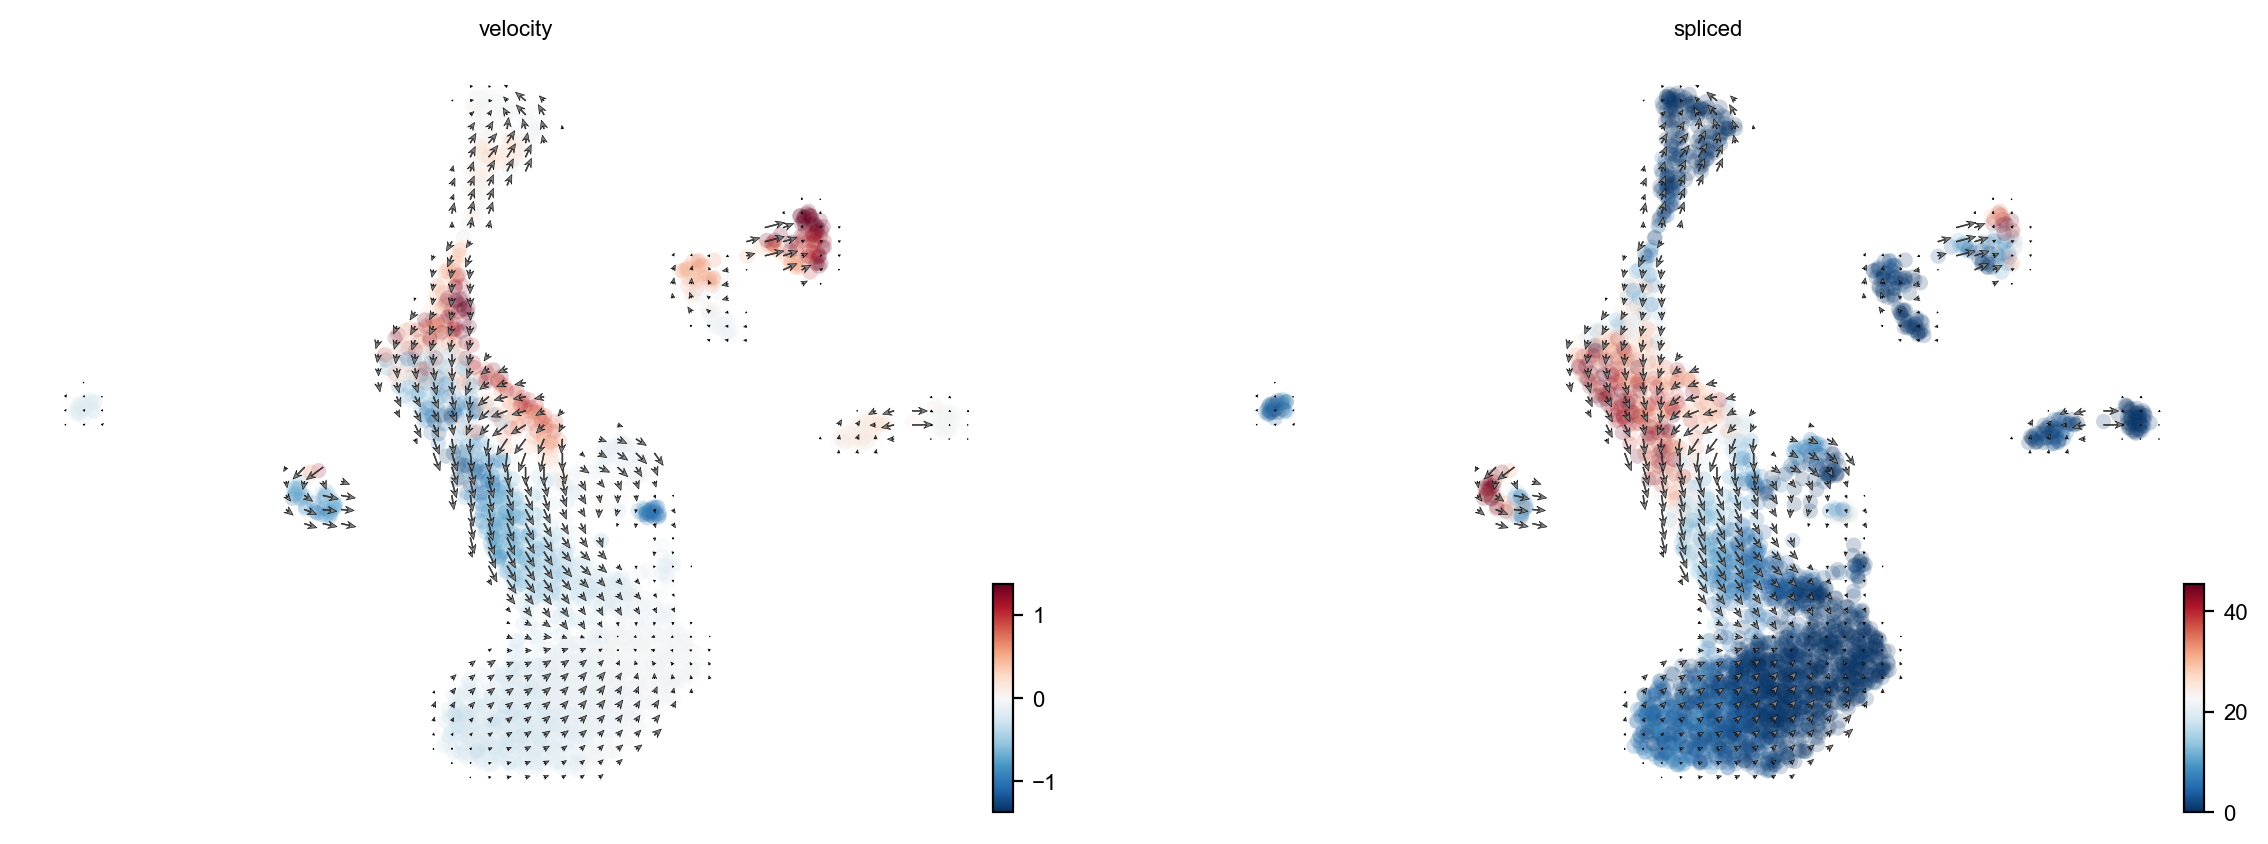

In [13]:
scv.pl.velocity_embedding_grid(adata, color='Tmsb10',
                               layer=['velocity', 'spliced'], arrow_size=1.5)

In [5]:
adata

AnnData object with n_obs × n_vars = 2930 × 2000 
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'clusters_colors', 'pca', 'neighbors', 'velocity_settings', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'

## my_velocity_embedding_grid function

In [4]:
from pandas import unique, Index
from ult import default_basis, default_size, default_color, get_components, default_arrow, make_unique_list, get_basis, velocity_embedding_changed,compute_velocity_on_grid,quiver_autoscale
import numpy as np
from scipy.stats import norm as normal
from matplotlib import rcParams
import matplotlib.pyplot as pl

In [5]:
def velocity_embedding_grid(adata, basis=None, vkey='velocity', density=None, smooth=None, min_mass=None, arrow_size=None,
                            arrow_length=None, arrow_color=None, scale=None, autoscale=True, n_neighbors=None,
                            recompute=None, X=None, V=None, X_grid=None, V_grid=None, principal_curve=False, color=None,
                            use_raw=None, layer=None, color_map=None, colorbar=True, palette=None, size=None, alpha=.2,
                            perc=None, sort_order=True, groups=None, components=None, projection='2d', legend_loc='none',
                            legend_fontsize=None, legend_fontweight=None, xlabel=None, ylabel=None, title=None,
                            fontsize=None, figsize=None, dpi=None, frameon=None,show=True, save=None, ax=None, ncols=None, **kwargs):
    """\
    Scatter plot of velocities on a grid.

    Arguments
    ---------
    adata: :class:`~anndata.AnnData`
        Annotated data matrix.
    vkey: `str` or `None` (default: `None`)
        Key for annotations of observations/cells or variables/genes.
    density: `float` (default: 1)
        Amount of velocities to show - 0 none to 1 all
    arrow_size: `float` or 3-tuple for headlength, headwidth and headaxislength (default: 1)
        Size of arrows.
    arrow_length: `float` (default: 1)
        Length of arrows.
    scale: `float` (default: 1)
        Length of velocities in the embedding.
    min_mass: `float` or `None` (default: `None`)
        Minimum threshold for mass to be shown. It can range between 0 (all velocities) and 100 (large velocities).
    smooth: `float` (default: 0.5)
        Multiplication factor for scale in Gaussian kernel around grid point.
    n_neighbors: `int` (default: None)
        Number of neighbors to consider around grid point.
    X: `np.ndarray` (default: None)
        embedding grid point coordinates
    V: `np.ndarray` (default: None)
        embedding grid velocity coordinates
    {scatter}

    Returns
    -------
        `matplotlib.Axis` if `show==False`
    """
    print("call this function")
    basis = default_basis(adata) if basis is None else get_basis(adata, basis)
    vkey = [key for key in adata.layers.keys() if 'velocity' in key and '_u' not in key] if vkey is 'all' else vkey
    colors, layers, vkeys = make_unique_list(color, allow_array=True), make_unique_list(layer), make_unique_list(vkey)

    if V is None:
        for key in vkeys:
            if recompute or velocity_embedding_changed(adata, basis=basis, vkey=key):
                #velocity_embedding(adata, basis=basis, vkey=key)
                scv.pl.velocity_embedding(adata, basis=basis, vkey=key)
    color, layer, vkey = colors[0], layers[0], vkeys[0]
    color = default_color(adata) if color is None else color

    if X_grid is None or V_grid is None:
        print("x and v is None")
        _adata = adata[groups_to_bool(adata, groups, groupby=color)] \
            if groups is not None and color in adata.obs.keys() else adata
        X_emb  = np.array(_adata.obsm['X_' + basis][:, get_components(components, basis)]) if X is None else X[:, :2]
        V_emb = np.array(_adata.obsm[vkey + '_' + basis][:, get_components(components, basis)]) if V is None else V[:, :2]
        X_grid, V_grid = compute_velocity_on_grid(X_emb=X_emb, V_emb=V_emb, density=density, autoscale=autoscale,
                                                  smooth=smooth, n_neighbors=n_neighbors, min_mass=min_mass)
        print(X_grid.shape)
        print("-"*20)
        print(V_grid.shape)
        np.savetxt("XgridData.txt", X_grid)
        np.savetxt("VgridData.txt", V_grid)
        global scatter_kwargs
        scatter_kwargs = {"basis": basis, "perc": perc, "use_raw": use_raw, "sort_order": sort_order, "alpha": alpha,
                      "components": components, "projection": projection, "legend_loc": legend_loc, "groups": groups,
                      "legend_fontsize": legend_fontsize, "legend_fontweight": legend_fontweight, "palette": palette,
                      "color_map": color_map, "frameon": frameon, "xlabel": xlabel, "ylabel": ylabel,
                      "colorbar": colorbar, "dpi": dpi, "fontsize": fontsize, "show": False, "save": False}

    multikey = colors if len(colors) > 1 else layers if len(layers) > 1 else vkeys if len(vkeys) > 1 else None
    if multikey is not None:
        if title is None: title = list(multikey)
        elif isinstance(title, (list, tuple)): title *= int(np.ceil(len(multikey) / len(title)))
        ncols = len(multikey) if ncols is None else min(len(multikey), ncols)
        nrows = int(np.ceil(len(multikey) / ncols))
        figsize = rcParams['figure.figsize'] if figsize is None else figsize
        ax = []
        for i, gs in enumerate(
                pl.GridSpec(nrows, ncols, pl.figure(None, (figsize[0] * ncols, figsize[1] * nrows), dpi=dpi))):
            if i < len(multikey):
                print(" --layer--: ",layers[i])
                ax.append(velocity_embedding_grid(adata, density=density, scale=scale, size=size,
                                                  min_mass=min_mass, smooth=smooth, n_neighbors=n_neighbors,
                                                  principal_curve=principal_curve, ax=pl.subplot(gs),
                                                  arrow_size=arrow_size, arrow_length=arrow_length,
                                                  color=colors[i] if len(colors) > 1 else color,
                                                  layer=layers[i] if len(layers) > 1 else layer,
                                                  vkey=vkeys[i] if len(vkeys) > 1 else vkey,
                                                  title=title[i] if isinstance(title, (list, tuple)) else title,
                                                  X_grid=None if len(vkeys) > 1 else X_grid,
                                                  V_grid=None if len(vkeys) > 1 else V_grid,
                                                  autoscale=False if len(vkeys) > 1 else autoscale,
                                                  **scatter_kwargs, **kwargs))
        #savefig_or_show(dpi=dpi, save=save, show=show)
        print("type -- 1", ax)
        return ax

    else:
        if(ax is None):
            print("ax none")
        else:
            print("--ax--is--",ax)
        ax = pl.figure(None, figsize, dpi=dpi).gca() if ax is None else ax

        hl, hw, hal = default_arrow(arrow_size)
        scale = 1 / arrow_length if arrow_length is not None else scale if scale is not None else 1
        quiver_kwargs = {"scale": scale, "angles": 'xy', "scale_units": 'xy', "width": .001,
                         "color": 'grey' if arrow_color is None else arrow_color, "edgecolors": 'k',
                         "headlength": hl/2, "headwidth": hw/2, "headaxislength": hal/2, "linewidth": .2}
        for arg in list(kwargs):
            if arg in quiver_kwargs: quiver_kwargs.update({arg: kwargs[arg]})
            else: scatter_kwargs.update({arg: kwargs[arg]})

        ax.quiver(X_grid[:, 0], X_grid[:, 1], V_grid[:, 0], V_grid[:, 1], **quiver_kwargs, zorder=3)
                ## X_grid: start coordinate of arrow
                ## V_grid: x and y components of arrow
        if principal_curve:
            curve = adata.uns['principal_curve']['projections']
            pl.plot(curve[:, 0], curve[:, 1], c="w", lw=6, zorder=4)
            pl.plot(curve[:, 0], curve[:, 1], c="k", lw=3, zorder=5)

        size = 4 * default_size(adata,'scvelo') if size is None else size
        ax = scv.pl.scatter(adata, layer=layer, color=color, size=size, title=title, ax=ax, zorder=0, **scatter_kwargs)
        print("type -- 2", ax)
        #savefig_or_show(dpi=dpi, save=save, show=show)
        return ax

call this function
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


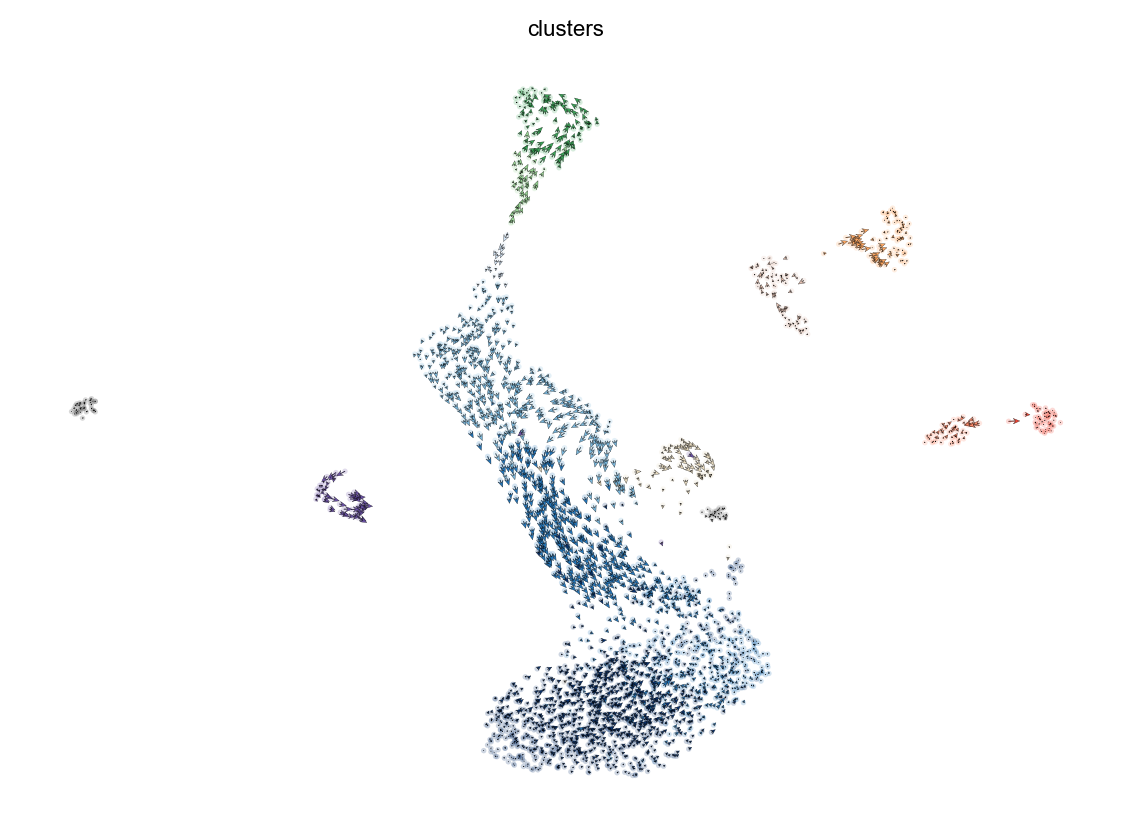

x and v is None
(540, 2)
--------------------
(540, 2)
 --layer--:  velocity
call this function
--ax--is-- AxesSubplot(0.18,0.15;0.354545x0.76)
type -- 2 AxesSubplot(0.18,0.15;0.354545x0.76)
 --layer--:  spliced
call this function
--ax--is-- AxesSubplot(0.605455,0.15;0.354545x0.76)
type -- 2 AxesSubplot(0.605455,0.15;0.354545x0.76)
type -- 1 [<matplotlib.axes._subplots.AxesSubplot object at 0x1a298775d0>, <matplotlib.axes._subplots.AxesSubplot object at 0x1a294b6a10>]


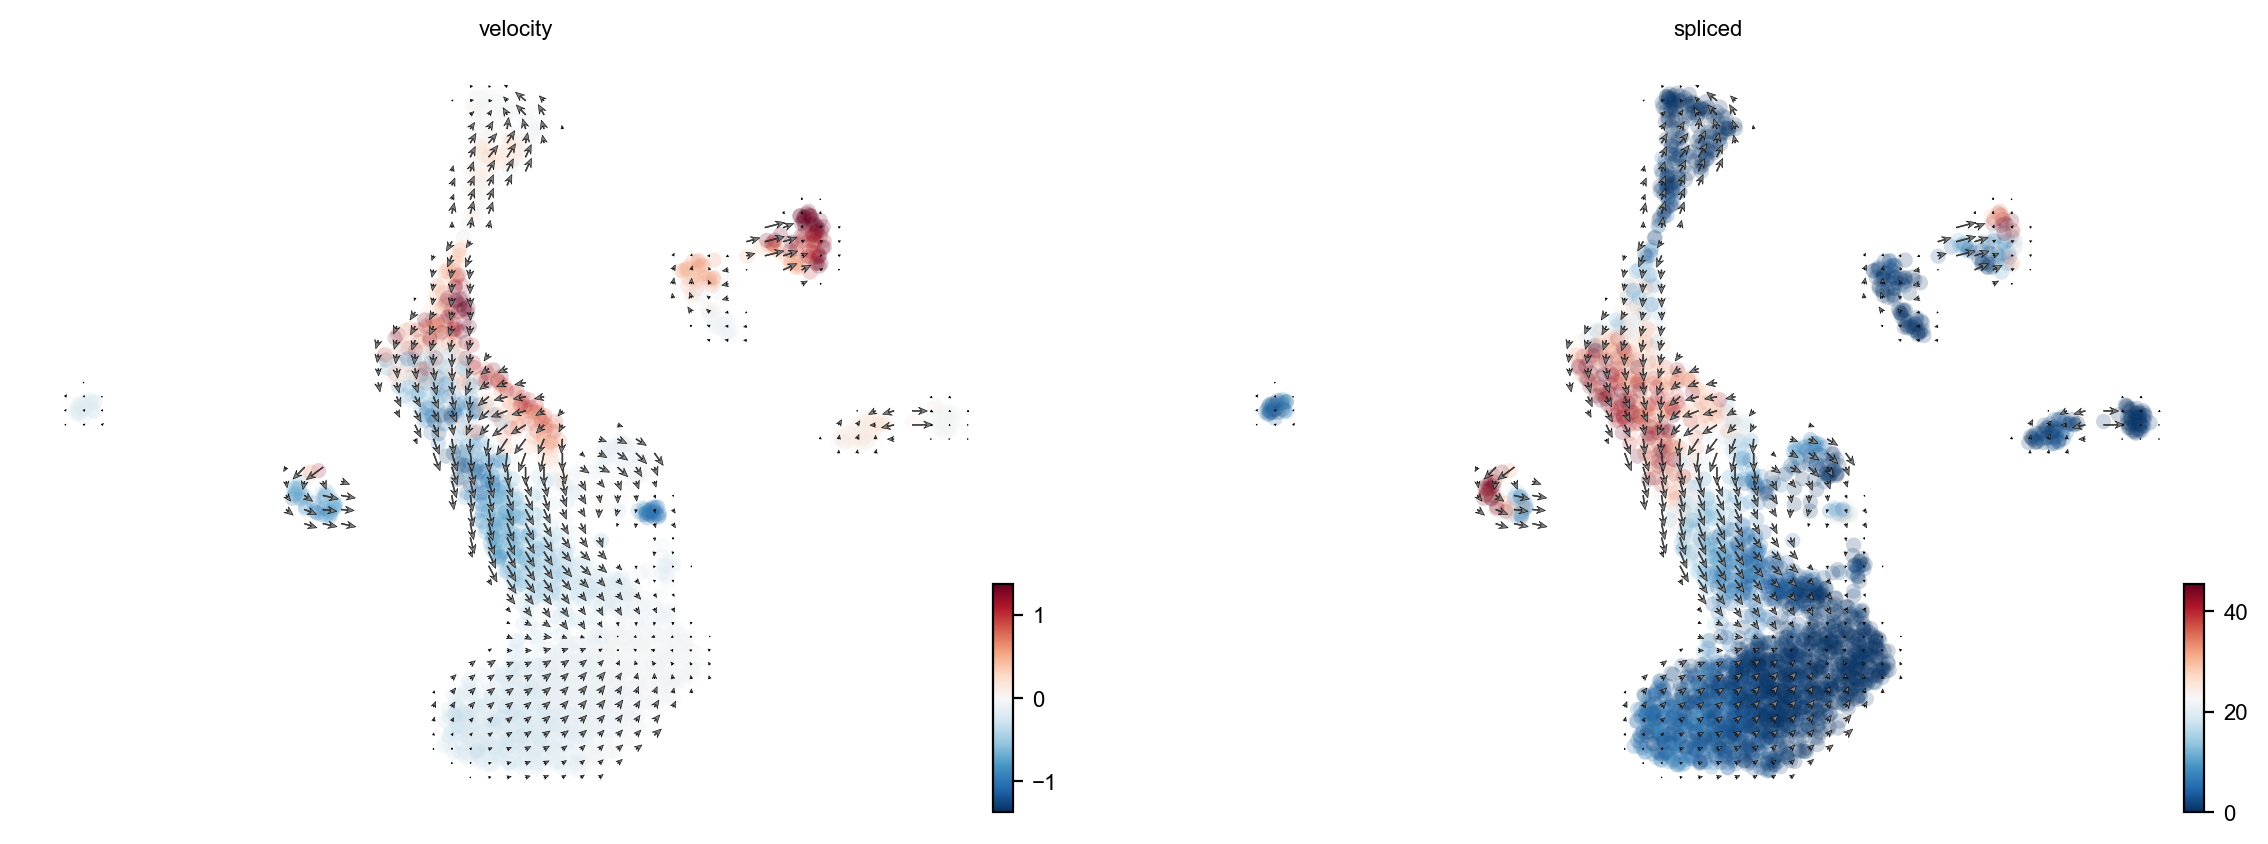

In [6]:
velocity_embedding_grid(adata, color='Tmsb10',layer=['velocity', 'spliced'], arrow_size=1.5)